In [1]:
import networkx as nx 
import numpy as np 
import scipy.stats as sts
import matplotlib.pyplot as plt
import pylab as py 
import matplotlib
%matplotlib inline 
import seaborn as sns

# Building Simulation

In [2]:
class Tag_Friends:
    def __init__(self, p=0.2, y = 3):
        self.prob_tagging = p 
        self.tags = y
        self.timestep = 0

        self.followers = 25
        self.g = nx.barabasi_albert_graph(self.followers, 3)
        self.not_tagged = list(self.g.nodes)

        # Set intensity of support
        for i in range(len(self.g.nodes)):
            intensity = np.random.beta(8,2)
            self.g.nodes[i]["intensity"] = intensity
        
        # Set strength of relationship 
        for i,j in self.g.edges:
            self.g.edges[i,j]["weight"] = np.random.beta(6,4)

        self.g.pos = nx.spring_layout(self.g)

        # Parameters for change in relationship
        self.alpha =  0.6
        self.beta = 0.2
        self.gamma = 0.2
        
        # Store model metrics
        self.metrics = []
        self.intensity_mean = []
        self.intensity_sd = []
        
    def update(self):
        tagged = []
        # Select people to post weighted by support
        if len(self.not_tagged)>0:
            p = np.array([self.g.nodes[nd]["intensity"] for nd in self.not_tagged])
            nds = np.random.choice(self.not_tagged, 
                size = np.random.poisson(self.prob_tagging*len(self.not_tagged)), p = p/sum(p))
        else: 
            return

        # Select which nodes to add to network
        for nd in nds:
            for tag in range(self.tags):
                intensity = np.random.beta(2,8)
                if intensity > 0.5:
                    j = self.pref_select(nd) # Connect node to an existing node preferentially
                    new_nd = len(self.g.nodes)
                    self.g.add_node(new_nd, intensity = intensity )
                    self.g.add_edge(nd, new_nd, weight = np.random.beta(5,5))
                    self.g.add_edge(new_nd, j, weight = np.random.beta(5,5))                    
                    tagged.append(new_nd)

        # Update list of nodes who haven't tagged others yet
        self.not_tagged = np.unique(np.append(self.not_tagged, tagged))

        # Store follower count at the end of each day
        if self.timestep >24:
            self.metrics.append(len(list(self.g.nodes))-self.followers)
        
        self.timestep +=1
    
    def relationship(self):
        # Update relationships
        self.nextg = self.g.copy()

        # Change values based on adaptive model rules
        for i in self.g.nodes:
            ci = self.g.nodes[i]["intensity"]
            self.nextg.nodes[i]['intensity'] =  ci + self.alpha * ( \
                sum((self.g.nodes[j]['intensity'] - ci) * self.g.edges[i,j]['weight']
                    for j in self.g.neighbors(i))) *0.01
        for i, j in self.g.edges:
            wij = self.g.edges[i,j]['weight']
            self.nextg.edges[i,j]['weight'] = wij + self.beta * wij * (1 - wij) * ( \
                1 - self.gamma * abs(self.g.nodes[i]['intensity'] - self.g.nodes[j]['intensity'])
                ) *0.01
        self.g, self.nextg = self.nextg, self.g

        # Store metrics for intensity of support
        intensity =[self.g.nodes[j]["intensity"] for j in list(self.g.nodes)]
        self.intensity_mean.append(np.mean(intensity))
        self.intensity_sd.append(np.std(intensity))

        self.timestep +=1

    def pref_select(self, nd):
        # Preferential selection of nodes
        nds = list(self.g.nodes)
        nds.remove(nd)
        degree = np.array([self.g.degree[i] for i in nds])
        cumulative = degree.cumsum()
        index = cumulative.searchsorted(np.random.uniform(0, cumulative[-1]))
        return nds[index]

    def observe(self):
        py.cla()
        nx.draw(self.g, vmin = 0, vmax = 1,
            node_color = [self.g.nodes[i]['intensity'] for i in self.g.nodes],
            edge_cmap = py.cm.binary, edge_vmin = 0, edge_vmax = 1)
            # edge_color = [self.g.edges[i,j]['weight'] for i, j in self.g.edges],
            # pos = self.g.pos)

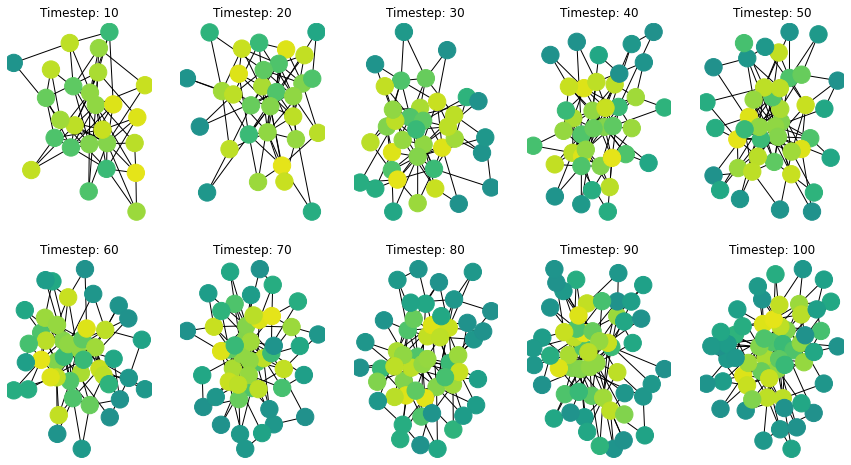

In [40]:
test = Tag_Friends(p=0.2, y = 2)
plt.figure(figsize=(15,8))
t = np.arange(1,101)
pos = 1
for i in t:
    test.update()
    if i%10 ==0:
        ax = plt.subplot(2,5, pos)
        pos +=1
        test.observe()
        ax.set_title(f"Timestep: {i}")

In [4]:
class Post_Story(Tag_Friends):
    def __init__(self, p=0.02):
        super().__init__(p=0.02)
        # Set number of followers
        for i in range(len(self.g.nodes)):
            self.g.nodes[i]["followers"] = round(sts.skewnorm.rvs(5, loc = 60, scale = 40))

    def update(self):
        tagged = []
        # Select people to post weighted by support
        if len(self.not_tagged)>0:
            p = np.array([self.g.nodes[nd]["intensity"] for nd in self.not_tagged])
            nds = np.random.choice(self.not_tagged, 
                size = np.random.poisson(self.prob_tagging*len(self.not_tagged)), p = p/sum(p))
        else: 
            return
        
        # Choose successful nodes to add to network
        for nd in self.not_tagged:
            if self.g.nodes[nd]["intensity"]*self.prob_tagging > np.random.random():
                intensity = np.random.beta(0.01, 0.99, 
                    size = round(0.25*self.g.nodes[nd]["followers"]))
                intensity = intensity[np.where(intensity>0.5)]
                for i in intensity:
                    new_nd = len(self.g.nodes)
                    self.g.add_node(new_nd, intensity = i, 
                        followers = round(sts.skewnorm.rvs(5, loc = 60, scale = 40)))
                    self.g.add_edge(nd, new_nd, weight = np.random.beta(5,5))
                    self.g.add_edge(j, new_nd, weight = np.random.beta(5,5))
                    tagged.append(new_nd)

        # Update list of nodes that haven't pariticpated in giveaway
        self.not_tagged = np.unique(np.append(self.not_tagged, tagged))

        if self.timestep >24:
            self.metrics.append(len(list(self.g.nodes))-self.followers)
        
        self.timestep +=1

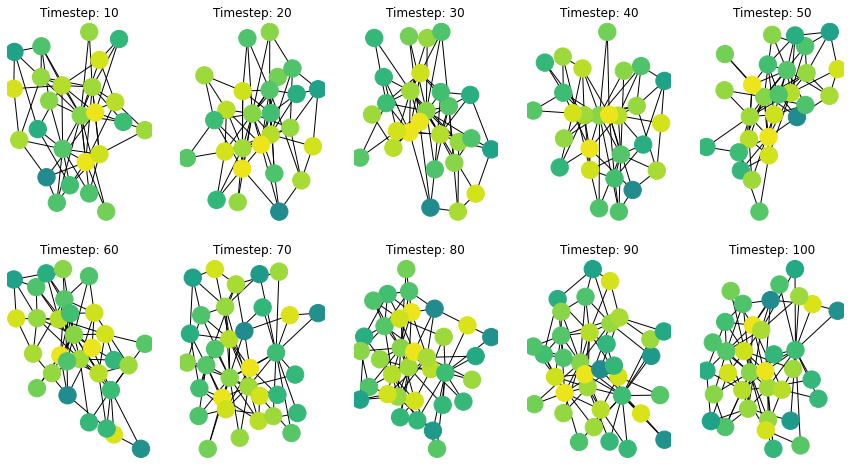

In [41]:
test = Post_Story(p=0.02)
plt.figure(figsize=(15,8))
t = np.arange(1,101)
pos = 1
for i in t:
    test.update()
    if i%10 ==0:
        ax = plt.subplot(2,5, pos)
        pos +=1
        test.observe()
        ax.set_title(f"Timestep: {i}")

In [3]:
p = np.arange(2, 11, 2)/100
y = np.arange(1,6)

# Tagging Friends
mean_tag = []
intensity_mean_tag = []
intensity_sd_tag = []

for i, tag in enumerate(y):
    for j, prob in enumerate(p):
        metrics = []
        mean_intensity=[]
        sd_intensity = []
        for _ in range(100):
            m = Tag_Friends(prob, tag)
            for _ in range(241):
                m.update()
            metrics.append(m.metrics)
            for _ in range(30):
                m.relationship()
            mean_intensity.append(m.intensity_mean)
            sd_intensity.append(m.intensity_sd)
        mean_tag.append(metrics)
        intensity_mean_tag.append(mean_intensity)
        intensity_sd_tag.append(sd_intensity)

In [5]:
# Posting Story
mean_post = []
intensity_mean_post = []
intensity_sd_post = []

for j, prob in enumerate(p):
    mean_intensity=[]
    sd_intensity = []
    metrics =[]
    for _ in range(100):
        m = Post_Story(prob)
        for _ in range(241):
            m.update()
        metrics.append(m.metrics)
        for _ in range(30):
            m.relationship()
        mean_intensity.append(m.intensity_mean)
        sd_intensity.append(m.intensity_sd)
    mean_post.append(metrics)
    intensity_mean_post.append(mean_intensity)
    intensity_sd_post.append(sd_intensity)

# Growth of Reach

## Tagging Friends

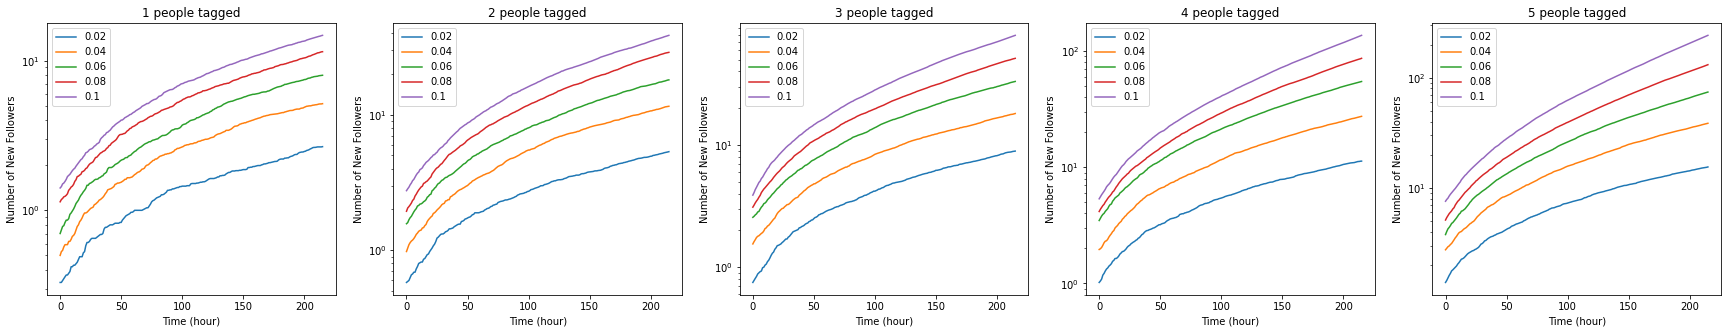

In [6]:
plt.figure(figsize = (30,5))
reduced = np.mean(mean_tag, axis = 1)
for j in range(len(y)):
    plt.subplot(1,5,j+1)
    for i in range(len(p)):
        plt.plot(np.arange(216), reduced[i+j*len(p)], label = "{:2g}".format(p[i]))
        plt.yscale("log")
        plt.title(f"{y[j]} people tagged")
    plt.xlabel("Time (hour)")
    plt.legend()
    plt.ylabel("Number of New Followers")
plt.show()

## Posting Instagram Story

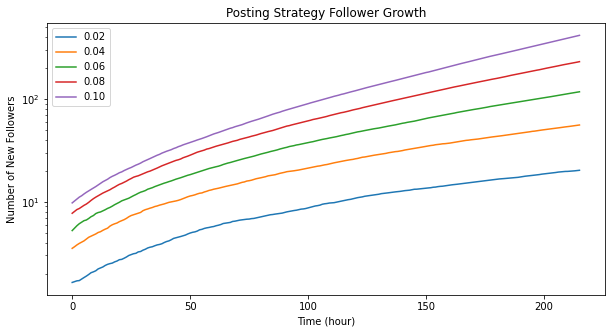

In [7]:
plt.figure(figsize = (10,5))
norm = np.mean(mean_post, axis = 1)
for i in range(len(p)):
    plt.plot(np.arange(216), norm[i], label = "{:.2f}".format(p[i]))
plt.yscale("log")
plt.title(f"Posting Strategy Follower Growth")
plt.xlabel("Time (hour)")
plt.legend()
plt.ylabel("Number of New Followers")
plt.show()

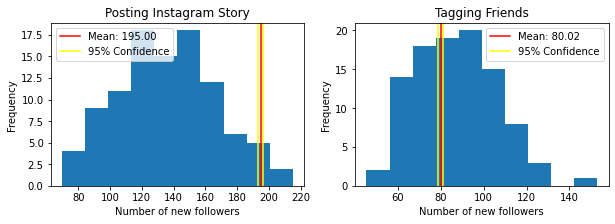

In [8]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(np.mean(mean_post[-1], axis =1))
ci = 1.96*np.std(mean_post[-1], axis =1)[-1]/np.mean(mean_post[-1], axis =1)[-1]
plt.axvline(np.mean(mean_post[-1], axis =1)[-1], c= "r", label = f"Mean: {'{:.2f}'.format(np.mean(mean_post[-1], axis =1)[-1])}")
plt.axvline(np.mean(mean_post[-1], axis =1)[-1]+ci, c = "yellow", label = "95% Confidence")
plt.axvline(np.mean(mean_post[-1], axis =1)[-1]-ci, c = "yellow")
plt.xlabel("Number of new followers")
plt.ylabel("Frequency")
plt.title("Posting Instagram Story")
plt.legend()
plt.subplot(1,2,2)
plt.hist(np.mean(mean_tag[-1], axis =1))
plt.axvline(np.mean(mean_tag[-1], axis =1)[-1], c = "r", label = f"Mean: {'{:.2f}'.format(np.mean(mean_tag[-1], axis =1)[-1])}")
ci = 1.96*np.std(mean_tag[-1], axis =1)[-1]/np.mean(mean_tag[-1], axis =1)[-1]
plt.axvline(np.mean(mean_tag[-1], axis =1)[-1] +ci, c = "yellow", label = "95% Confidence")
plt.axvline(np.mean(mean_tag[-1], axis =1)[-1] -ci, c = "yellow")
plt.xlabel("Number of new followers")
plt.ylabel("Frequency")
plt.title("Tagging Friends")
plt.legend()
plt.show()

# Growth of Sales
## Tagging Friends

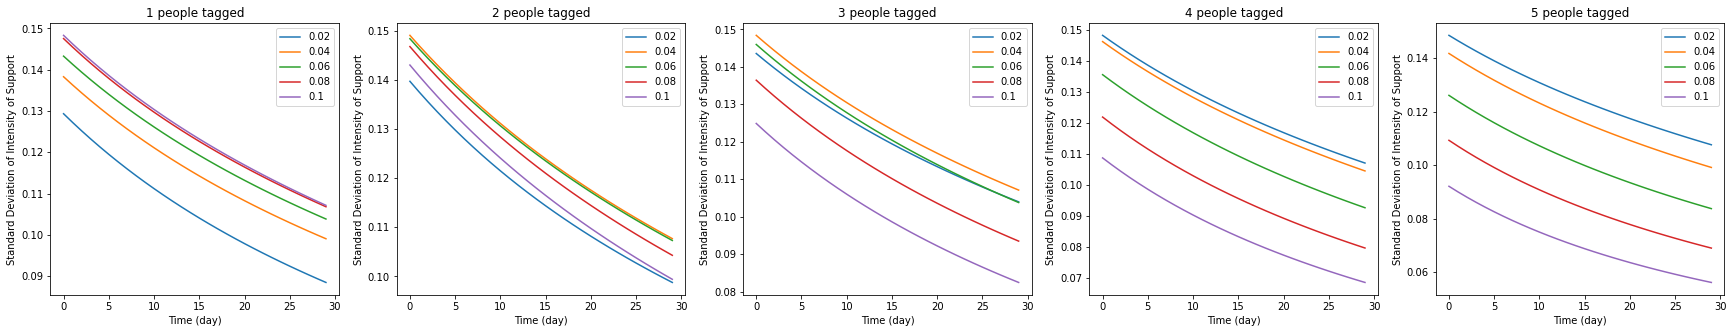

In [9]:
plt.figure(figsize = (30,5))
p = np.arange(2, 11, 2)/100

intensity_sd = np.mean(intensity_sd_tag, axis = 1)
for j in range(len(y)):
    plt.subplot(1,5,j+1)
    for i in range(len(p)):
        plt.plot(np.arange(30), intensity_sd[i+j*len(p)], label = "{:2g}".format(p[i]) )
        plt.title(f"{y[j]} people tagged")
    plt.xlabel("Time (day)")
    plt.legend()
    plt.ylabel("Standard Deviation of Intensity of Support")
plt.show()

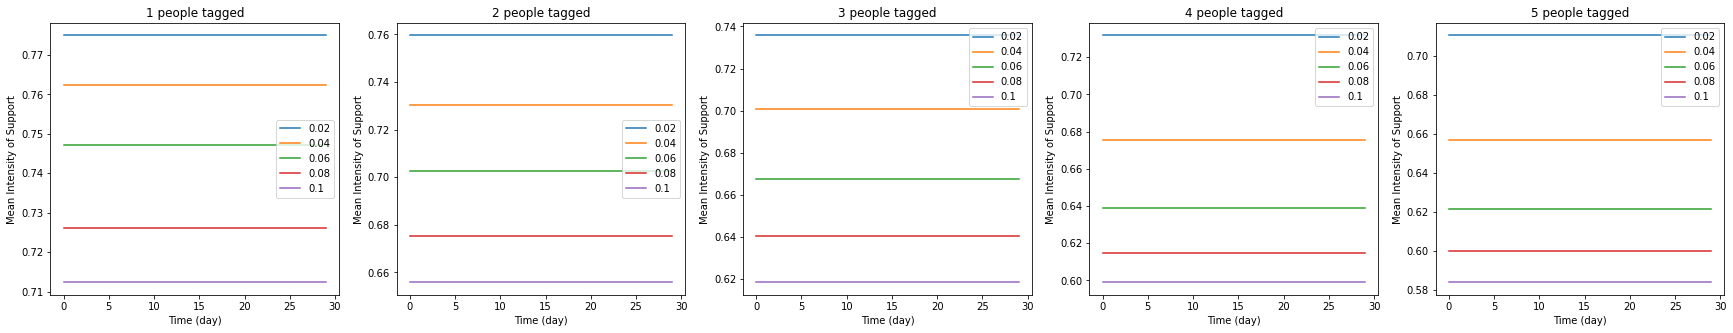

In [10]:
plt.figure(figsize = (30,5))
intense = np.mean(intensity_mean_tag, axis = 1)
for j in range(len(y)):
    plt.subplot(1,5,j+1)
    for i in range(len(p)):
        plt.plot(np.arange(30), intense[i+j*len(p)], label = "{:2g}".format(p[i]))
        # plt.plot(np.arange(241), intensity_sd_tag[i+j*len(p)]+intensity_mean_tag[i+j*len(p)])
        # plt.plot(np.arange(241), -intensity_sd_tag[i+j*len(p)]+intensity_mean_tag[i+j*len(p)])
        plt.title(f"{y[j]} people tagged")
    plt.xlabel("Time (day)")
    plt.legend()
    plt.ylabel("Mean Intensity of Support")
plt.show()

## Posting Instagram Story

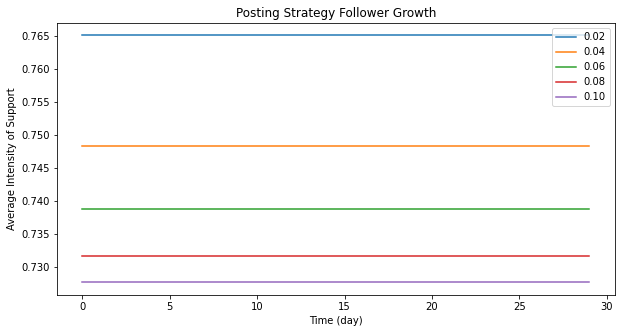

In [11]:
plt.figure(figsize = (10,5))
norm = np.mean(intensity_mean_post, axis = 1)
for i in range(len(p)):
    plt.plot(np.arange(30), norm[i], label = "{:.2f}".format(p[i]))
plt.title(f"Posting Strategy Follower Growth")
plt.xlabel("Time (day)")
plt.legend()
plt.ylabel("Average Intensity of Support")
plt.show()

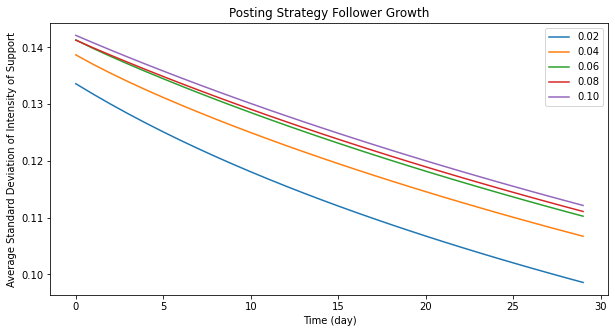

In [12]:
plt.figure(figsize = (10,5))
norm = np.mean(intensity_sd_post, axis = 1)
for i in range(len(p)):
    plt.plot(np.arange(30), norm[i], label = "{:.2f}".format(p[i]))
plt.title(f"Posting Strategy Follower Growth")
plt.xlabel("Time (day)")
plt.legend()
plt.ylabel("Average Standard Deviation of Intensity of Support")
plt.show()

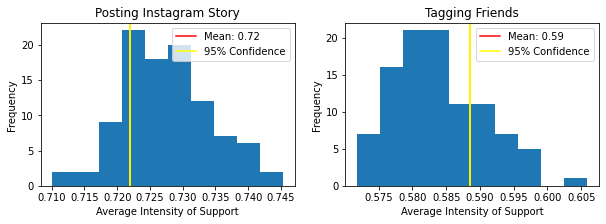

In [13]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(np.mean(intensity_mean_post[-1], axis =1))
ci = 1.96*np.std(intensity_mean_post[-1], axis =1)[-1]/np.mean(intensity_mean_post[-1], axis =1)[-1]
plt.axvline(np.mean(intensity_mean_post[-1], axis =1)[-1], c= "r", label = f"Mean: {'{:.2f}'.format(np.mean(intensity_mean_post[-1], axis =1)[-1])}")
plt.axvline(np.mean(intensity_mean_post[-1], axis =1)[-1]+ci, c = "yellow", label = "95% Confidence")
plt.axvline(np.mean(intensity_mean_post[-1], axis =1)[-1]-ci, c = "yellow")
plt.xlabel("Average Intensity of Support")
plt.ylabel("Frequency")
plt.title("Posting Instagram Story")
plt.legend()
plt.subplot(1,2,2)
plt.hist(np.mean(intensity_mean_tag[-1], axis =1))
plt.axvline(np.mean(intensity_mean_tag[-1], axis =1)[-1], c = "r", label = f"Mean: {'{:.2f}'.format(np.mean(intensity_mean_tag[-1], axis =1)[-1])}")
ci = 1.96*np.std(intensity_mean_tag[-1], axis =1)[-1]/np.mean(intensity_mean_tag[-1], axis =1)[-1]
plt.axvline(np.mean(intensity_mean_tag[-1], axis =1)[-1] +ci, c = "yellow", label = "95% Confidence")
plt.axvline(np.mean(intensity_mean_tag[-1], axis =1)[-1] -ci, c = "yellow")
plt.xlabel("Average Intensity of Support")
plt.ylabel("Frequency")
plt.title("Tagging Friends")
plt.legend()
plt.show()

# Theoretical Analysis of Follower Growth

In [14]:
def r(p,q): 
    """ Common ratio """
    return (1/(0.00195*p*q+1-p)  -1 )*100

p = np.arange(1,11)/100
q = np.arange(1,11)
results = np.zeros((len(p), len(q)))

for i, prob in enumerate(p):
    for j, tag in enumerate(q):
        results[i][j] = r(prob, tag)

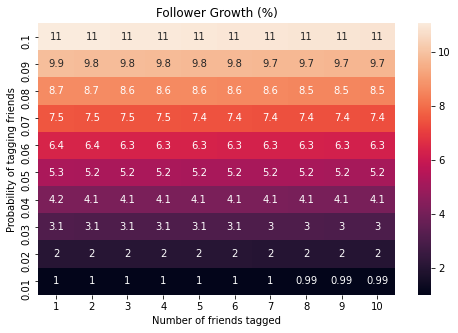

In [15]:
plt.figure(figsize=(8,5))
ax = sns.heatmap(results, annot = True)
ax.invert_yaxis()
ax.set_yticklabels(p)
ax.set_xticklabels(q)
ax.set_ylabel("Probability of tagging friends")
ax.set_xlabel("Number of friends tagged")
ax.set_title("Follower Growth (%)")
plt.show()